## Umgebung vorbereiten

In [1]:
!pwd

/content


In [2]:
!git clone https://github.com/edadunashvili/ThePrax.git

fatal: destination path 'ThePrax' already exists and is not an empty directory.


In [3]:
cd ThePrax

/content/ThePrax


In [4]:
!pwd

/content/ThePrax


In [5]:
!pip install pyprind

In [6]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Korpus von Trainingsdaten erstellen

 !!! Den gesuchten Typ bestimmen !!!

In [7]:
typNum='300'
episode_string_train = "a300_string_train.csv"
episode_roh_train = "a300_roh_train.csv"

Vorhandener gleichnamiger Korpus wird gelöscht 

In [8]:
import os
if os.path.exists(episode_string_train):
    os.remove(episode_string_train)
else:
    print("Diese Datei existiert nicht")

Im Ordner "Trainingsdaten" nach den entsprechenden Textdateien suchen und in einer rohe Datei zusammentragen

In [9]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_train,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_train, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []


for file in glob.glob("Trainingsdaten/*.txt"):
    
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [10]:
fin = open(episode_roh_train,'r', encoding ='utf-8')
fout = open(episode_string_train, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Liste von einmaligen Episoden aus der CSV Datei zeigen

In [11]:
import pandas as pd
df = pd.read_csv(episode_string_train, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({"'e300_e_vorfeld_des_kampfes_bis_zum_sieg'": 41, "'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'": 36, "'e300_o_auftritt_des_helden_vor_dem_koenig_bis_zum_ende_der_geschichte'": 34, "'e300_g_nach_dem_sieg_bis_zur_trennung_des_befreiers_und_der_befreiten'": 30, "'e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag'": 28, "'e554_a_'": 20, "'e300_m_rueckkehr_des_helden_ _von_der_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit'": 19, "'e303_c_eingangssituation_bis_zur_trennung'": 16, "'e303_g_erstes_treffen_mit_der_hexen'": 16, "'e303_i_vom_erkundigung_der_not_bis_zum_aufbruch_des_helden_zur_hexe'": 15, "'e303_k_vom_afbruch_zur_hexe_bis_zur_ihren_ueberweltigung'": 15, "'eundf_a_'": 13, "'e315_a_'": 12, "'ecom_a_'": 11, "'e300_l_wiederbelebung_des_helden'": 8, "'e550_a_'": 7, "'e300_i_rueckkehr_der_koenigstochter_und_die_suche_nach_dem_held retter'": 7, "'e301_a_'": 7, "'e562_a_'": 6, "'e303_m_eifersucht'": 5, "'e328_a_'": 4, "'e303_q_rueckk

## Modell erstellen und trainieren

Bibliotheken laden

In [12]:
import keras
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pyprind
import pandas as pd
import random
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from keras import backend as K
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers
from keras.preprocessing import sequence

Using TensorFlow backend.


!!! Variable anpassen !!!

In [13]:
ziel_episode = 'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'
mini_frequenz = 2
k_fach = 5
layD = 96
episode_string_train = 'a300_string_train.csv' 
episode_binar_train = 'a300_binar_train.csv'

Aufbereitung der Trainingsdaten.
Rohdaten laden und und den Episodenbestand betrachten

In [14]:
fin = open(episode_string_train,'r', encoding='utf-8') 
fout = open(episode_binar_train, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))  
fin.close()
fout.close()

Die in der CSV Datei etikettierte Episoden auflisten

In [15]:
df = pd.read_csv(episode_binar_train, encoding='utf-8')
indexliste=Counter(df.index_string)
print(*indexliste, sep='\n')

ecom_a_
e303_c_eingangssituation_bis_zur_trennung
e300_c_anfangssituation_ankunft_und_erkundigung_der_not
e300_e_vorfeld_des_kampfes_bis_zum_sieg
e300_g_nach_dem_sieg_bis_zur_trennung_des_befreiers_und_der_befreiten
e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag
e300_m_rueckkehr_des_helden_ _von_der_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit
e300_o_auftritt_des_helden_vor_dem_koenig_bis_zum_ende_der_geschichte
e303_g_erstes_treffen_mit_der_hexen
e303_i_vom_erkundigung_der_not_bis_zum_aufbruch_des_helden_zur_hexe
e303_k_vom_afbruch_zur_hexe_bis_zur_ihren_ueberweltigung
e315_a_
e554_a_
e550_a_
eundf_a_
e300_i_rueckkehr_der_koenigstochter_und_die_suche_nach_dem_held retter
eamom_a_
e516_a_
e513a_a_
e302_a_
e301_a_
e300_l_wiederbelebung_des_helden
e328_a_
e567_a_
e590_a_
e303_m_eifersucht
e303_o_erloesung_der_hexe
e303_q_rueckkehr_und_finale
e562_a_
e314_a_
e850_a_


Die gesuchte Episode etikettieren und den Rohdaten in Trainingsdaten umwandeln

In [16]:
for i,e in enumerate(df.index_string):
    if e == ziel_episode:
        df.index_binar[i]='1'
    else: 
        df.index_binar[i]='0'

In [17]:
df.to_csv(episode_binar_train, encoding='utf-8', index=False)

Trainngsdaten aufbereiten. Das Vorkommen jedes Wortes zählen

In [18]:
nltk.download('stopwords')
w = stopwords.words('german')
counts = Counter()
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Vorkommen der Wörter zählen')
for i, episode in enumerate(df['episode']): 
        pbar.update()
        counts.update(episode.split())
new_counts = {}
for k, v in counts.items():
    if v > mini_frequenz and k not in w:
        new_counts[k] = v
counts = Counter(new_counts)

Vorkommen der Wörter zählen


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [19]:
#print(counts)

Zuordnung erzeugen und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [20]:
word_counts = sorted(counts, key=counts.get, reverse=True)
word_to_int = {word: ii for ii, word in enumerate(word_counts,0)}
mapped_episoden = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()
mapped_episoden = [list(filter(None, el)) for el in mapped_episoden]

Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [21]:
#print(word_to_int)

In [22]:
#print(mapped_episoden[0])

Traiingsndaten und Trainingslabels bestimmen

In [23]:
train_data = mapped_episoden[0:] 
train_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ",
      "train_data =", len (train_data))

sequences = 2593   train_data = 368


Trainingsdaten und -Labels vektorisieren

In [24]:
sequences_laenge=max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data) 
y_train = np.asarray(train_labels).astype('float32')

In [25]:
for i, element in enumerate(x_train[0]):
    print(i,'-', element)

0 - 0.0
1 - 1.0
2 - 1.0
3 - 0.0
4 - 0.0
5 - 0.0
6 - 0.0
7 - 0.0
8 - 0.0
9 - 0.0
10 - 0.0
11 - 0.0
12 - 1.0
13 - 0.0
14 - 0.0
15 - 0.0
16 - 1.0
17 - 0.0
18 - 0.0
19 - 0.0
20 - 0.0
21 - 0.0
22 - 0.0
23 - 0.0
24 - 0.0
25 - 0.0
26 - 0.0
27 - 0.0
28 - 1.0
29 - 1.0
30 - 0.0
31 - 0.0
32 - 0.0
33 - 0.0
34 - 0.0
35 - 1.0
36 - 0.0
37 - 0.0
38 - 0.0
39 - 0.0
40 - 0.0
41 - 0.0
42 - 0.0
43 - 0.0
44 - 0.0
45 - 0.0
46 - 0.0
47 - 0.0
48 - 0.0
49 - 1.0
50 - 0.0
51 - 0.0
52 - 0.0
53 - 0.0
54 - 0.0
55 - 0.0
56 - 0.0
57 - 0.0
58 - 0.0
59 - 0.0
60 - 0.0
61 - 0.0
62 - 1.0
63 - 0.0
64 - 0.0
65 - 0.0
66 - 0.0
67 - 0.0
68 - 0.0
69 - 0.0
70 - 0.0
71 - 0.0
72 - 0.0
73 - 0.0
74 - 0.0
75 - 0.0
76 - 0.0
77 - 0.0
78 - 0.0
79 - 0.0
80 - 0.0
81 - 0.0
82 - 0.0
83 - 0.0
84 - 0.0
85 - 0.0
86 - 1.0
87 - 0.0
88 - 0.0
89 - 0.0
90 - 0.0
91 - 0.0
92 - 0.0
93 - 0.0
94 - 0.0
95 - 0.0
96 - 0.0
97 - 0.0
98 - 0.0
99 - 0.0
100 - 0.0
101 - 0.0
102 - 0.0
103 - 0.0
104 - 0.0
105 - 0.0
106 - 0.0
107 - 0.0
108 - 0.0
109 - 0.0
110 - 0.0


Neuronales Netz erzeugen

In [26]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(layD, activation='tanh',
                           input_shape=(sequences_laenge+1,)))
    #model.add(layers.Dense(layD, activation='relu'))
    model.add(layers.Dense(layD, activation='tanh')) 
    model.add(layers.Dense((1), activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['binary_accuracy'])
    return model

Neuronales Netz trainieren

In [27]:
k = k_fach
num_val_samples = len(x_train) // k 
num_epochs = 4
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_x_train, partial_y_train,
              epochs=num_epochs, batch_size = 8, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_binary_accuracy = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_binary_accuracy)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [28]:
all_scores

[0.9452054500579834,
 0.9589040875434875,
 0.9452054500579834,
 0.9726027250289917,
 0.9726027250289917]

In [29]:
np.mean(all_scores)

0.9589040875434875

In [30]:
num_epochs = 8
all_binary_accuracy_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size = 8, verbose=0)
    binary_accuracy_history = history.history['val_binary_accuracy']
    all_binary_accuracy_histories.append(binary_accuracy_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [31]:
average_binary_accuracy_history = [
    np.mean([x[i] for x in all_binary_accuracy_histories]) for i in range(num_epochs)]
for i, element in enumerate(average_binary_accuracy_history):
    print(i,'-', element)

0 - 0.9260273933410644
1 - 0.9616438269615173
2 - 0.9643835425376892
3 - 0.9589040994644165
4 - 0.9589040994644165
5 - 0.9589040994644165
6 - 0.9589040994644165
7 - 0.9589040994644165


## Messdaten erstellen

!!! Den gesuchten Typ bestimmen !!!

In [32]:
typNum =''
episode_string_mess = "gesamt_string_mess.csv"
episode_roh_mess = "gesamt_roh_mess.csv"
episode_binar_mess = "gesamt_binar_mess.csv"

Alte Datei mit gleichem Namen löschen

In [33]:
import os
if os.path.exists(episode_string_mess):
    os.remove(episode_string_mess)
else:
    print("Diese Datei existiert nicht")

Nach den entsprechenden Textdateien im Ordnet suchen und in einer rohe Datei zusammentragen

In [34]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_mess,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_mess, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []

for file in glob.glob("Messdaten/*.txt"):
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [35]:
fin = open(episode_roh_mess,'r', encoding ='utf-8')
fout = open(episode_string_mess, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Die in der CSV Datei etikettierte Episoden auflisten

In [36]:
import pandas as pd
df = pd.read_csv(episode_string_mess, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(*indexliste, sep='\n')

'0'
'e707_e_anfangssituation_erstes_treffen_bis_zur_schwangerschaft' 
'e707_g_abwesenheit_des_koenigs_bis_zur_bestrafung_der_koenigin'
'e707_i_getrenntes_leben_bis_zur_anregung_fuer_die_wunderbare_dinge_oder_aufklaerung'
'e707_k_setzen_der_vorletzten_herausforderung_aufgabe_des_ziels'
'e707_m_begegnung_mit_dem_helfer'
'e707_o_bei_der_erfuellung_der_vorletzten_herausforderung_aufgabe_des_ziels'
'e707_s_die_letzte_begegnung_mit_dem_helfer'
'e707_u_bei_der_erfuehlung_der_letzten_herausforderung_aufgabe_des_ziels'
'e707_w_wiedervereinigung_der_familie_bis_zur_bestraffung_der_antagonisten/antagonistin'


Messdaten laden und aufbereiten

In [37]:
fin = open(episode_string_mess,'r', encoding='utf-8') 
fout = open(episode_binar_mess, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))
                                 
fin.close()
fout.close()

In [38]:
df = pd.read_csv(episode_binar_mess, encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({'0': 147, 'e707_k_setzen_der_vorletzten_herausforderung_aufgabe_des_ziels': 2, 'e707_o_bei_der_erfuellung_der_vorletzten_herausforderung_aufgabe_des_ziels': 2, 'e707_e_anfangssituation_erstes_treffen_bis_zur_schwangerschaft ': 1, 'e707_g_abwesenheit_des_koenigs_bis_zur_bestrafung_der_koenigin': 1, 'e707_i_getrenntes_leben_bis_zur_anregung_fuer_die_wunderbare_dinge_oder_aufklaerung': 1, 'e707_m_begegnung_mit_dem_helfer': 1, 'e707_s_die_letzte_begegnung_mit_dem_helfer': 1, 'e707_u_bei_der_erfuehlung_der_letzten_herausforderung_aufgabe_des_ziels': 1, 'e707_w_wiedervereinigung_der_familie_bis_zur_bestraffung_der_antagonisten/antagonistin': 1})


In [39]:
for i,e in enumerate(df.index_string):
    if e:
        df.index_binar[i]='0'
    else: 
        df.index_binar[i]='0'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
df.to_csv(episode_binar_mess, encoding='utf-8', index=False)

Vorhandene Zuordnung laden und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [41]:
mapped_episoden_2 = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden_2.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()

mapped_episoden_2 = [list(filter(None, el)) for el in mapped_episoden_2]


Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


raiingsndaten und Trainingslabels bestimmen

In [42]:
mess_data = mapped_episoden_2[0:] 
mess_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ", 
      "mess_data =", len (mess_data))

sequences = 2593   mess_data = 158


Messdaten vektorisieren

In [43]:
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_mess = vectorize_sequences(mess_data)
y_mess = np.asarray(mess_labels).astype('float32')

## Messdaten analysieren

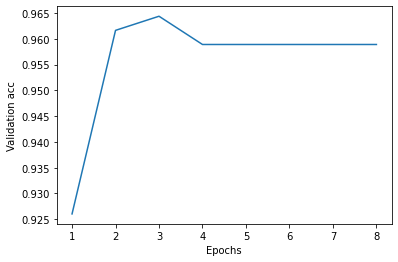

In [44]:
plt.plot(range(1, len(average_binary_accuracy_history) + 1), average_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

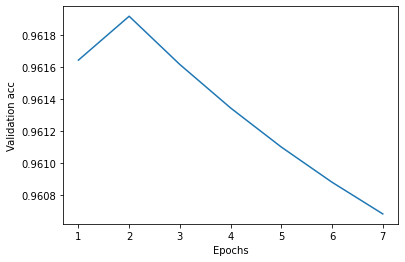

In [45]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_binary_accuracy_history = smooth_curve(average_binary_accuracy_history[1:])

plt.plot(range(1, len(smooth_binary_accuracy_history) + 1), smooth_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

Modell ausführen

In [46]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(x_train, y_train,
          epochs = 1, batch_size = 1)
mess_mse_score, mess_binary_accuracy_score = model.evaluate(x_mess, y_mess)

Epoch 1/1
158/158 [==============================] - 0s 195us/step


In [47]:
mess_binary_accuracy_score, mess_mse_score

(0.9303797483444214, 0.05925303782466092)

Voraussagen

In [48]:
predictions=model.predict(x_mess)
#for i in range(len(predictions)):
    #print(model.predict(x_mess))

In [49]:
print('Maximaler Wert:', max(max(model.predict(x_mess))))

Maximaler Wert: 0.9998495


Voraussgen in den aussortierten Datensätzen

In [50]:
mod_pred = model.predict(x_mess)
cutoff_value = 0.3
for i in range(len(y_mess)):
    if mod_pred[i,0]>cutoff_value:
        if ((i==0)|(mod_pred[i-1,0]>cutoff_value))|(mod_pred[i+0]>cutoff_value):
            #if df.index_string ==0:
                print (i+0,"-",
                  #i+2,"-", 
                  #y_test[i],"-", 
                  mod_pred[i],"-",
                  df.quelle[i+0],"-", 
                  df.episode[i+0],"-",
                  df.index_string[i+0],'\n')

14 - [0.48857078] - mess_44 - hinter mir dunkel und vorne mir klar - 0 

15 - [0.6092753] - mess_44 - dass niemand sehe wohin ich fahr - 0 

49 - [0.47021177] - mess_49 - seine hexenkunst hat hans nie mehr ausgeuebt da er bei seinem ersten versuch so viel angst hat ausstehen muessen und wenn einmal die rede aufs hexen kam soll hans immer gesagt haben das ist nichts fuer rechtschaffene leute - 0 

56 - [0.48426786] - mess_52 - damit war die muehle und die heerde von den riesen erloest und der jaeger ueber alle jaeger setzte seine reise fort er kam in eine stadt die ganz mit flor ueberzogen war weil ein drache die koenigstochter vom markte abholen wollte da stellte der jaeger ueber alle jaeger sich mit seinen treuen hunden neben die prinzessin und als der drache kam rief er ihm zu was du an den koenig zu fordern hast kannst du auch an mich fordern in demselben augenblicke sprangen die drei hunde stahl eisen und hille gegen den drachen an und zerrissen ihn - 0 

70 - [0.9998495] - 0_e300c

Voraussage: gewünschte Datensetze abrufen

In [51]:
for i in range(len(x_mess)):
    if i>121:
        print(i+0,"-",
              model.predict(x_mess)[i],"-",
              df.quelle[i+0],"-",
              df.episode[i+0],"-",
              df.index_string[i+0],'\n')

122 - [0.33762494] - mess_46 - er nahm ihn also vom haken und warf ihn wieder ins meer - 0 

123 - [0.14186662] - mess_46 - als er am abend nach hause kam und seiner frau erzaehlte was er gesehen und gehoert hatte wurde sie boese weil sie nichts zu essen hatten - 0 

124 - [0.28305387] - mess_46 - am naechsten morgen ging der fischer wieder zum fischen und fing das goldene fischchen noch einmal da sagte es ihm - 0 

125 - [0.25014424] - mess_46 -  jetzt gehoere ich dir du kannst mich essen aber bevor du mich isst werde ich dir einen ratschlag geben den du in deinem eigenen interesse befolgen solltest iss ein stueckchen und gib deiner frau auch eines zu essen dann wird sie zwillinge gebaeren danach nimm meine graeten und vergrab sie vor deinem haus dann werden zwei zypressen daraus spriessen dann nimm ein paar von ihren blaettern und fuettere alle tiere die du hast und sie werden auch zwillinge gebaeren - 0 

126 - [0.2582993] - mess_46 - und so geschah es nach einiger zeit bekamen sie 